Sample 2001-01-01–2024-01-01, train 2001-01-01–2024-01-01

=== Constant b_hat ===
   JP(GDP) : 0.006219
   US(GDP) : 0.133220
   EU(GDP) : 0.124814
   JP(CPI) : -0.071809
   US(CPI) : 0.061578
   EU(CPI) : -0.077995
   JP(HUR) : 0.057478
   US(HUR) : 0.213040
   EU(HUR) : -0.049033
       WTI : 2.929765
Initializing Kalman filter from constant GVAR(1)...


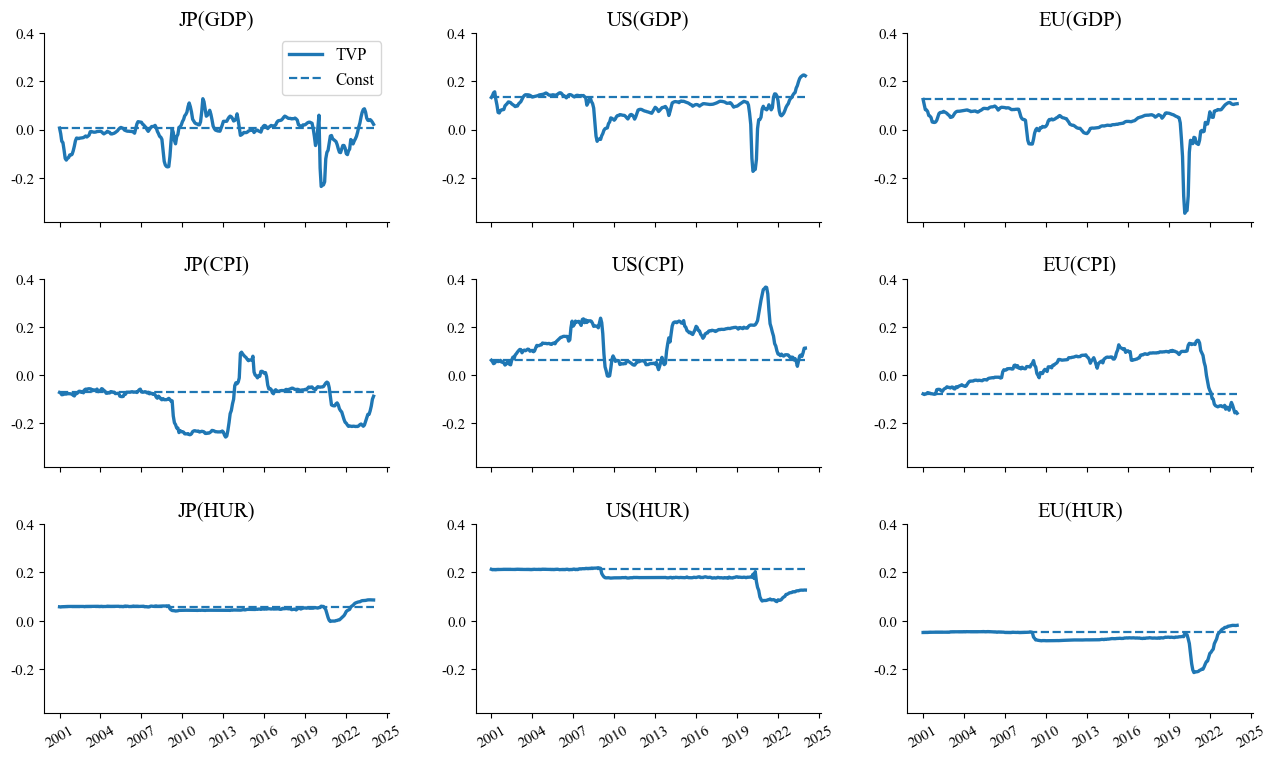

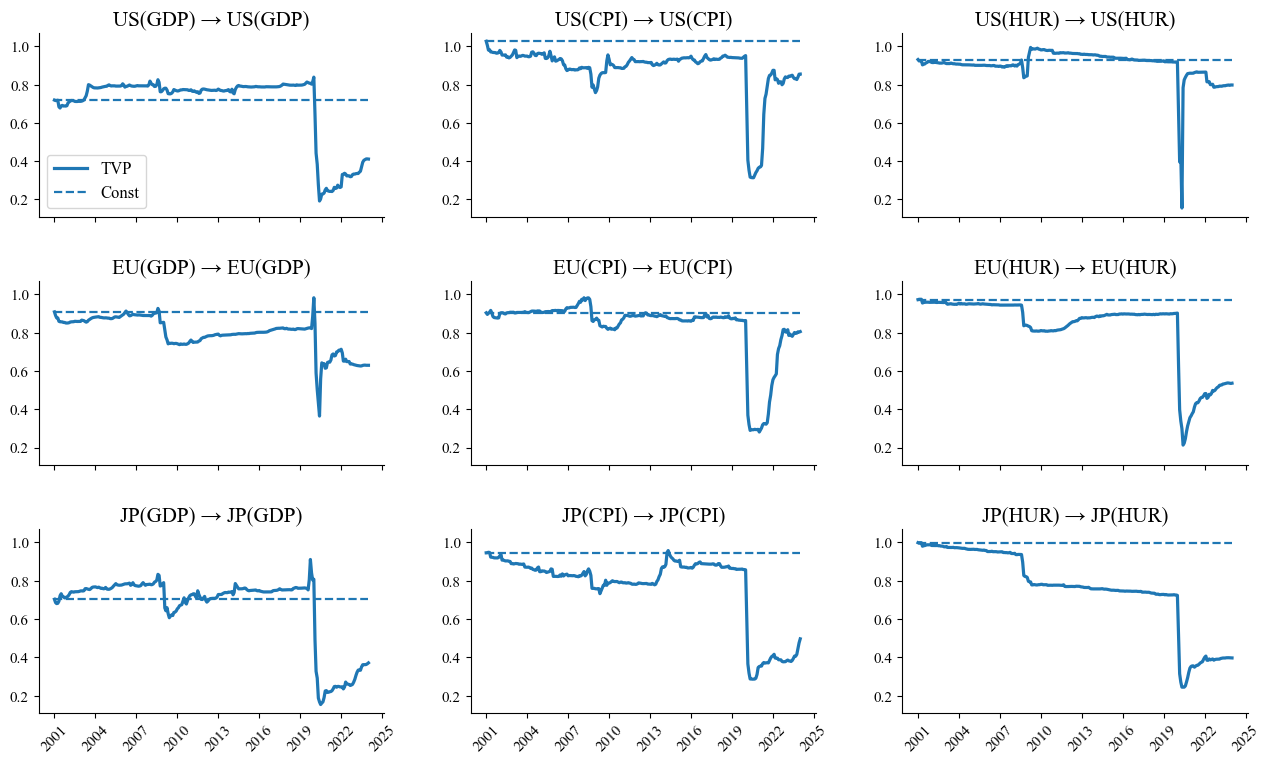

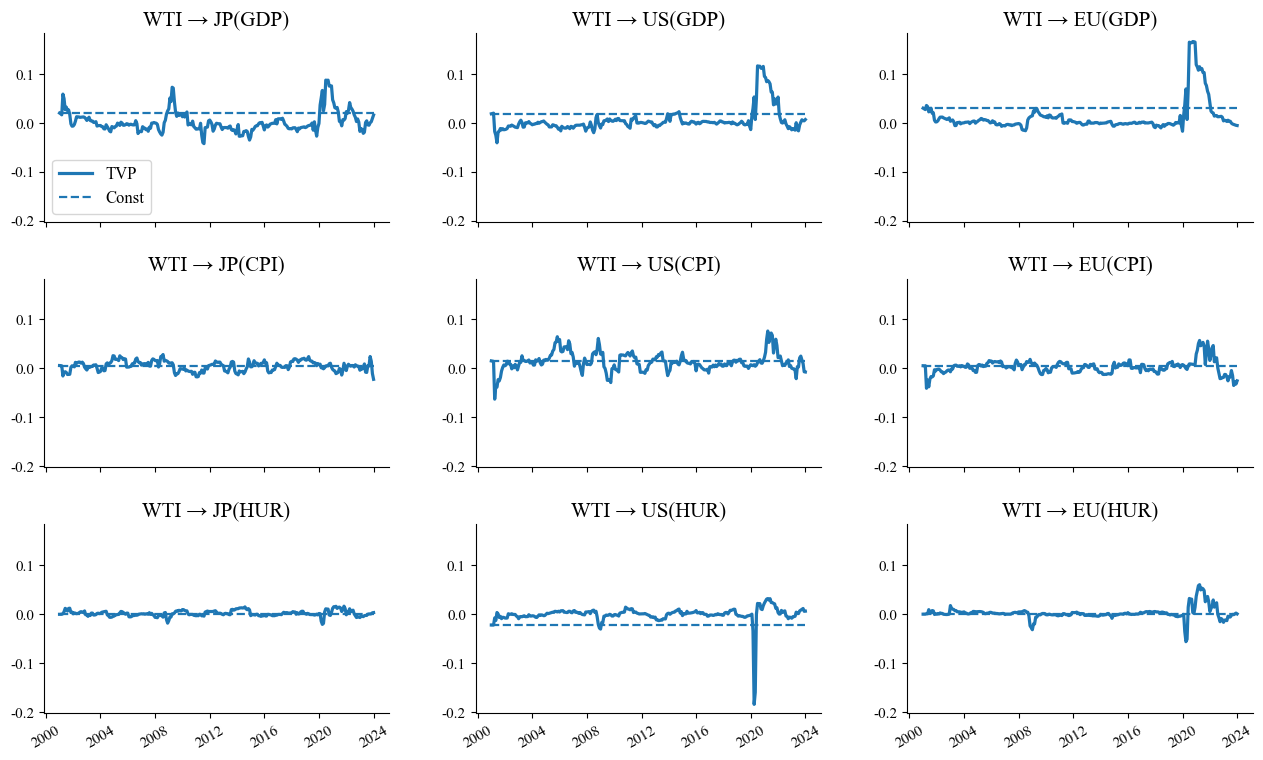

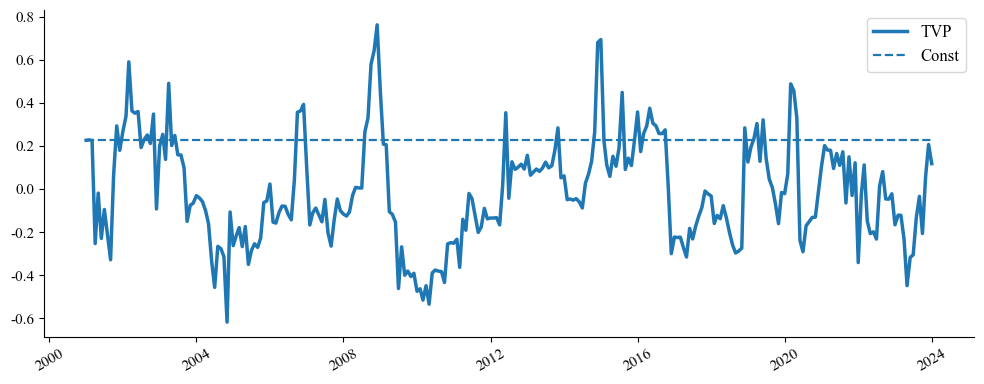

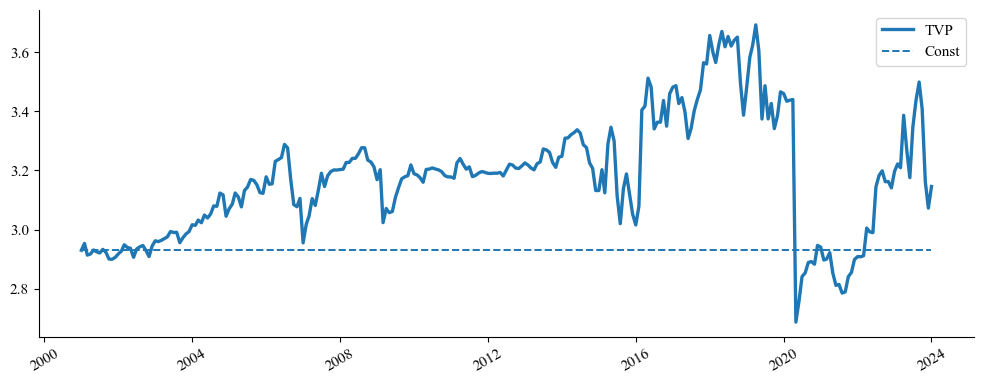

[Const OIRF Top 9] MBB block length: 1


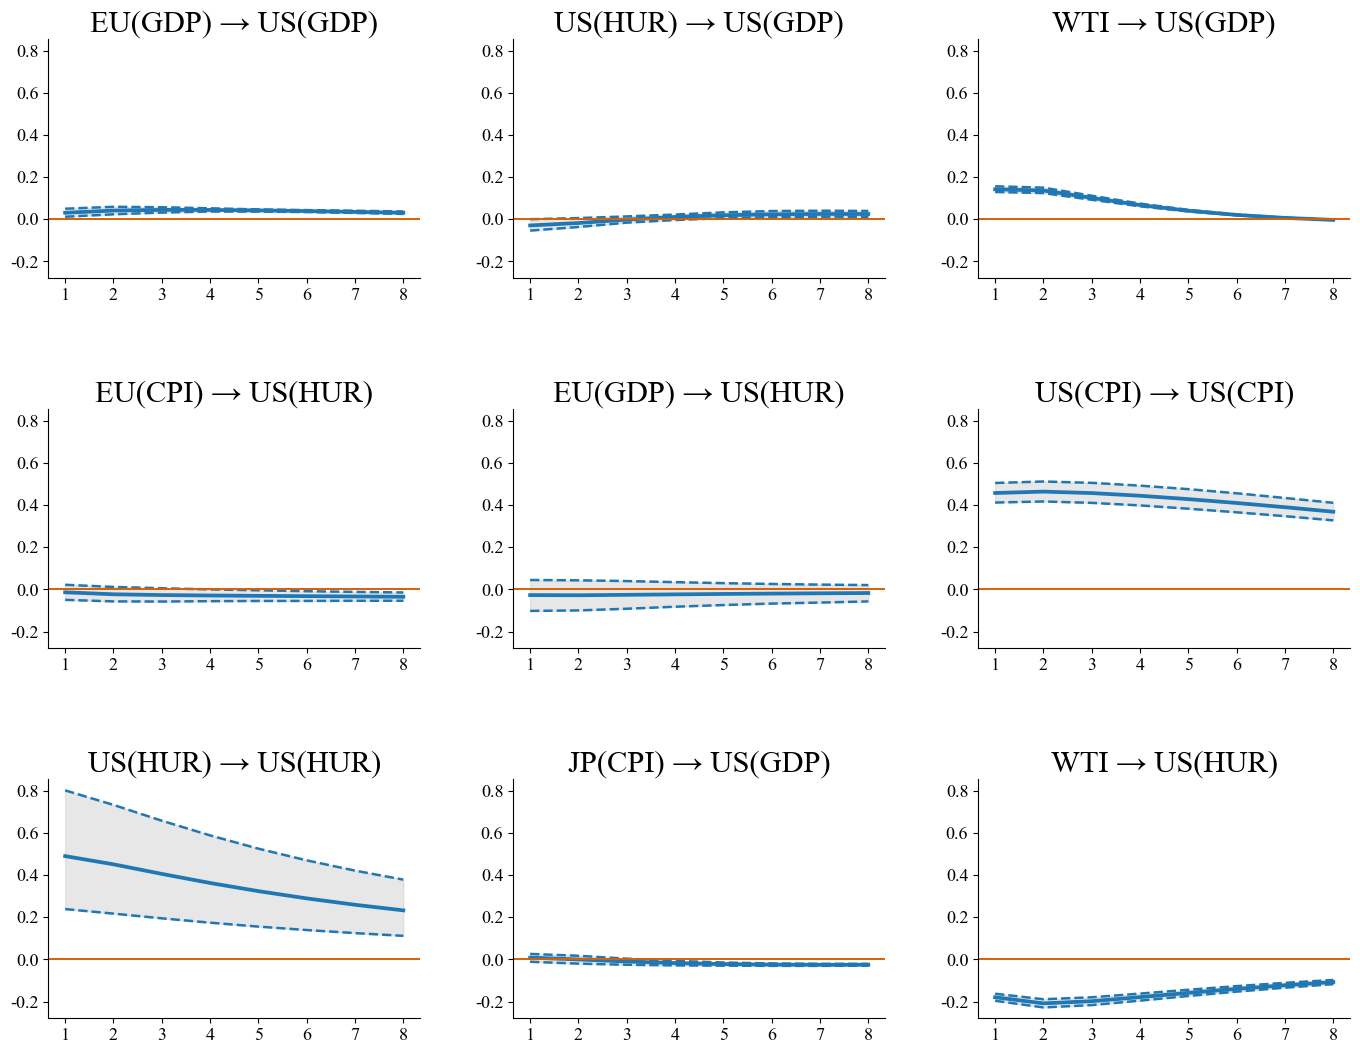

[Top 9 TVP-OIRF @ 2007-12-01] MBB block length: 1


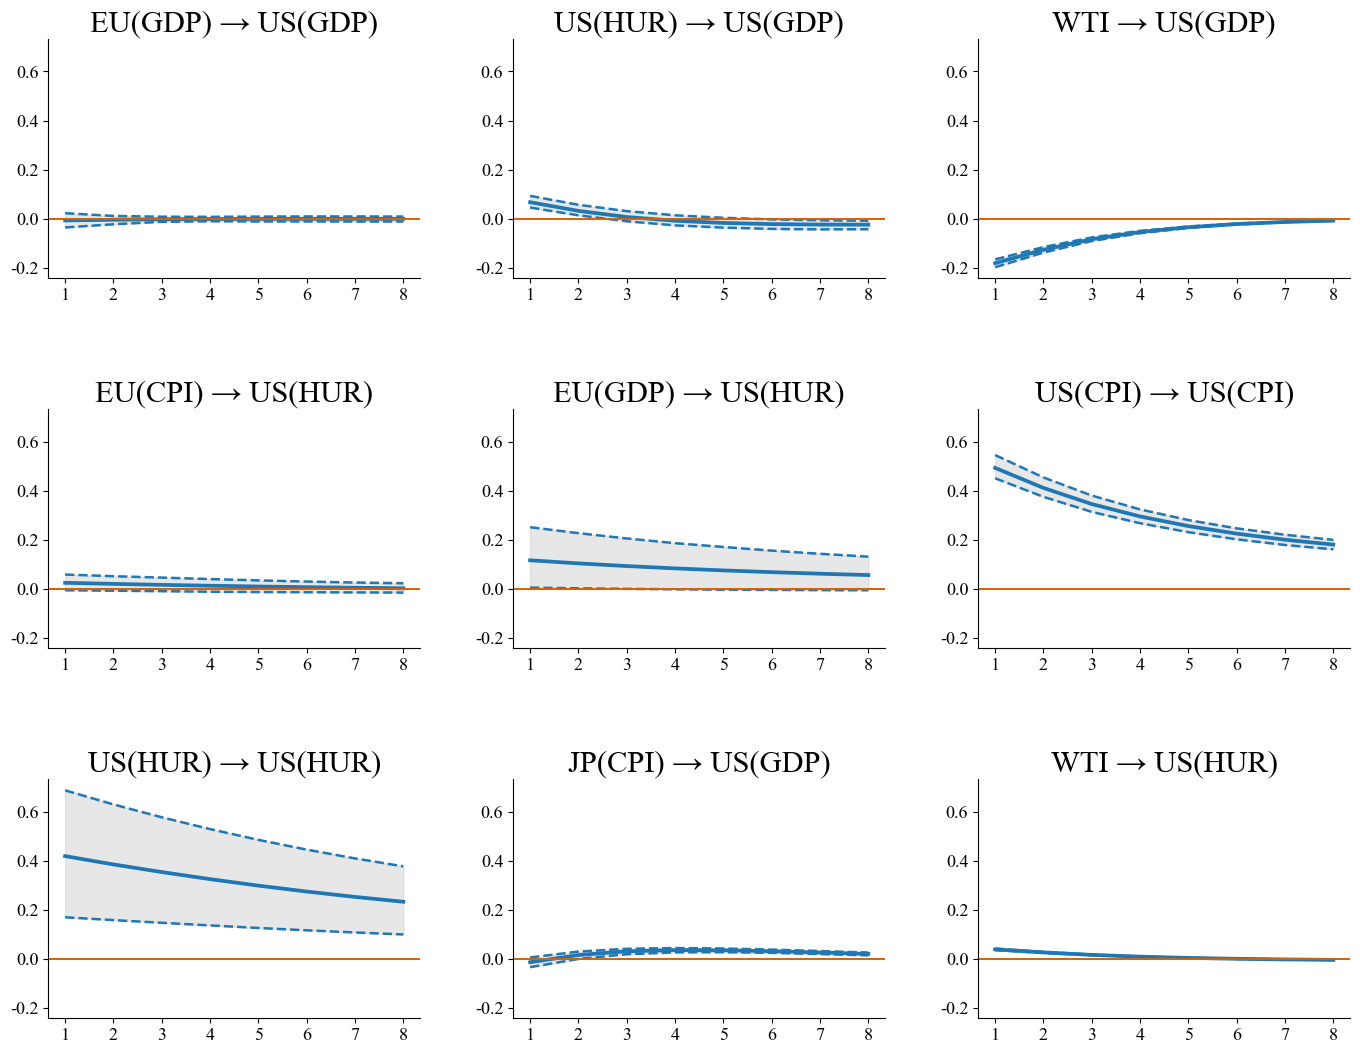

In [12]:
import os
import random
import warnings
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy.linalg import inv, eigvals, cholesky, LinAlgError
from statsmodels.tsa.stattools import acf

warnings.filterwarnings("ignore")

mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["font.sans-serif"] = ["Times New Roman"]
plt.rcParams.update(
    {
        "font.size": 12,
        "axes.titlesize": 13,
        "axes.labelsize": 12,
        "xtick.labelsize": 11,
        "ytick.labelsize": 11,
        "legend.fontsize": 10,
        "figure.titlesize": 16,
    }
)

BLUE = "#1f77b4"
ORANGE = "#d95f02"
GRAY = "#bdbdbd"

def style_ax(ax: plt.Axes) -> None:
    ax.spines[["top", "right"]].set_visible(False)
    ax.grid(False)

def fmt_var(name: str) -> str:
    if "_" not in name:
        return name
    a, b = name.split("_", 1)
    return f"{a}({b})"

def make_weights() -> np.ndarray:
    W = np.array(
        [
            [0.0, 0.137, 0.15],
            [0.45, 0.0, 0.85],
            [0.55, 0.863, 0.0],
        ],
        dtype=float,
    )
    np.fill_diagonal(W, 0.0)
    col = W.sum(axis=0, keepdims=True)
    col[col == 0] = 1.0
    W = W / col
    assert W.shape == (3, 3)
    return W


CPI_IDX = [0, 1, 2]
HUR_IDX = [3, 4, 5]
GDP_IDX = [6, 7, 8]
WTI_IDX = [9]

def make_gvar_mask() -> np.ndarray:
    M = np.zeros((10, 10))
    for grp in [CPI_IDX, HUR_IDX, GDP_IDX]:
        for r in grp:
            M[r, grp] = 1
            M[r, WTI_IDX] = 1
    M[WTI_IDX[0], :] = 1
    return M

GVAR_MASK = make_gvar_mask().astype(int)
W_E = make_weights()

# Bootstrap utilities
def choose_block_len(residuals, max_lag: int = 12) -> int:
    """Pick moving-block length from ACF decay."""
    acf_values = acf(residuals, nlags=max_lag)
    for lag in range(1, max_lag + 1):
        if np.abs(acf_values[lag]) < 0.2:
            return lag
    return max_lag

def mbb_resample(e_arr: np.ndarray, block_len: int, T_res: int) -> np.ndarray:
    """Moving-block bootstrap for residuals."""
    n = e_arr.shape[1]
    num_blocks = int(np.ceil(T_res / block_len))
    blocks = []
    max_start = T_res - block_len
    for _ in range(num_blocks):
        start_i = random.randint(0, max_start)
        blocks.append(e_arr[start_i : start_i + block_len, :])
    e_bs = np.vstack(blocks)
    return e_bs[:T_res, :]

def load_data(path: str, split_date: str = "2023-06-01"):
    df = pd.read_excel(path, parse_dates=["Date"]).set_index("Date")
    df = df[~df.index.duplicated()].sort_index().ffill()
    train = df.loc[:split_date].copy()
    test = df.loc[split_date:].copy()
    print(
        f"Sample {df.index[0].date()}–{df.index[-1].date()}, "
        f"train {train.index[0].date()}–{train.index[-1].date()}"
    )
    return df, train, test

def fit_const_gvar(df_train: pd.DataFrame, var_list, force_stable: bool = True, shrink: float = 0.98):
    """Estimate sparse VAR(1) consistent with GVAR structure."""
    X = df_train[var_list].values
    T, n = X.shape
    Z, Y = X[:-1, :], X[1:, :]

    b = np.zeros(n)
    F = np.zeros((n, n))
    for i in range(n):
        mask_i = GVAR_MASK[i].astype(bool)
        X_i = np.column_stack([np.ones(T - 1), Z[:, mask_i]])
        y_i = Y[:, i]
        beta_i, *_ = np.linalg.lstsq(X_i, y_i, rcond=None)
        b[i] = beta_i[0]
        F[i, mask_i] = beta_i[1:]

    if force_stable:
        eig_max = np.abs(eigvals(F)).max()
        if eig_max >= 1.0:
            F = F / (eig_max + 1e-12) * shrink
            new_rho = np.abs(eigvals(F)).max()
            print(
                f"[GVAR(1)] max eigenvalue {eig_max:.3f} >= 1; "
                f"shrink={shrink} -> new rho={new_rho:.3f}"
            )
    return b, F


def fit_tvp_gvar(
    df: pd.DataFrame,
    Q_b: float = 0.001,
    Q_f: float = 0.0005,
    reg_lambda: float = 0.005,
    force_stable: bool = True,
    ewma_lambda: float = 0.94,
):
    """Kalman-filter TVP-GVAR on stacked intercept and coefficients."""
    vars_all = df.columns.tolist()
    X = df.values
    T, n = X.shape
    dim = n + n * n

    print("Initializing Kalman filter from constant GVAR(1)...")
    const_b, const_F = fit_const_gvar(df, vars_all)
    theta = np.hstack([const_b, const_F.flatten()])
    P = np.eye(dim) * 0.1

    Q = np.zeros((dim, dim))
    Q[:n, :n] = Q_b * np.eye(n)
    Q[n:, n:] = Q_f * np.eye(n * n)
    R = np.eye(n) * (1.0 + reg_lambda)

    traj = np.zeros((T, dim))
    traj[0] = theta
    Sigma_t = np.zeros((T, n, n))
    Sigma_t[0] = np.eye(n)

    for t in range(1, T):
        # Predict
        th_pred = theta.copy()
        P_pred = P + Q

        xp = X[t - 1]
        H = np.zeros((n, dim))
        H[:, :n] = np.eye(n)
        for i in range(n):
            mask_i = GVAR_MASK[i].astype(bool)
            x_i = xp.copy()
            x_i[~mask_i] = 0.0
            H[i, n + i * n : n + (i + 1) * n] = x_i

        v = X[t] - H @ th_pred
        S = H @ P_pred @ H.T + R
        K = P_pred @ H.T @ inv(S)
        theta = th_pred + K @ v
        P = (np.eye(dim) - K @ H) @ P_pred

        b, F = theta[:n], theta[n:].reshape(n, n)
        if force_stable:
            lam = np.abs(eigvals(F)).max()
            cnt = 0
            while lam >= 1.0 and cnt < 200:
                F *= 0.98
                lam = np.abs(eigvals(F)).max()
                cnt += 1
        F *= GVAR_MASK
        theta = np.hstack([b, F.flatten()])
        traj[t] = theta

        eps_t = X[t] - (b + F @ X[t - 1])
        Sigma_t[t] = ewma_lambda * Sigma_t[t - 1] + (1 - ewma_lambda) * np.outer(eps_t, eps_t)

    return traj, vars_all, Sigma_t

# IRFs
def irf(
    F: np.ndarray,
    b: np.ndarray,
    shock_idx: int,
    resp_idx: int,
    horizon: int = 12,
    chol_P: np.ndarray | None = None,
    use_intercept: bool = True,
    include_step0: bool = True,
) -> np.ndarray:
    n = F.shape[0]
    I = np.eye(n)
    try:
        x_star = inv(I - F) @ b if (use_intercept and b is not None) else np.zeros(n)
    except LinAlgError:
        x_star = np.zeros(n)

    e = np.zeros(n)
    if chol_P is not None:
        e = chol_P[:, shock_idx]
    else:
        e[shock_idx] = 1.0

    base = x_star.copy()
    shock = x_star + e
    out = [shock[resp_idx] - base[resp_idx]] if include_step0 else []

    for _ in range(horizon):
        if use_intercept and b is not None:
            base = F @ base + b
            shock = F @ shock + b
        else:
            base = F @ base
            shock = F @ shock
        out.append(shock[resp_idx] - base[resp_idx])

    return np.array(out)

def plot_const_oirf_all(
    const_b,
    const_F,
    var_list,
    df_train,
    horizon: int = 8,
    n_sims: int = 300,
    max_lag: int = 12,
):
    print("\n=== Constant GVAR OIRF (MBB 95% CI) ===")
    n = len(var_list)
    X = df_train[var_list].values
    T_res = len(X) - 1

    residuals = np.array([X[t] - (const_b + const_F @ X[t - 1]) for t in range(1, len(X))])
    blk = choose_block_len(residuals.ravel(), max_lag)
    print(f"MBB block length: {blk}")

    us_idx = [var_list.index(v) for v in ["US_GDP", "US_CPI", "US_HUR"]]
    shocks = range(n)
    tgrid = np.arange(1, horizon + 1)

    ymins, ymaxs = [], []
    store = {}

    for i in shocks:
        for r in us_idx:
            sims = []
            for _ in range(n_sims):
                e_bs = mbb_resample(residuals, blk, T_res)
                Sig = e_bs.T @ e_bs / max(T_res - 1, 1) + 1e-6 * np.eye(n)
                C_bs = cholesky(Sig)
                path = irf(
                    const_F,
                    const_b,
                    i,
                    r,
                    horizon,
                    chol_P=C_bs,
                    use_intercept=True,
                    include_step0=True,
                )
                sims.append(path[1:])

            sims = np.vstack(sims)
            lo, hi = np.percentile(sims, [5, 95], axis=0)
            mu = sims.mean(0)

            store[(i, r)] = (lo, hi, mu)
            ymins.append(lo.min())
            ymaxs.append(hi.max())

    pad = 0.05 * (max(ymaxs) - min(ymins) + 1e-12)
    y_lim = (min(ymins) - pad, max(ymaxs) + pad)

    fig, axes = plt.subplots(n, len(us_idx), figsize=(16, 4 * n))
    plt.subplots_adjust(left=0.05, right=0.98, top=0.95, bottom=0.06, wspace=0.25, hspace=0.35)

    for i in shocks:
        for j, r in enumerate(us_idx):
            ax = axes[i, j]
            style_ax(ax)

            lo, hi, mu = store[(i, r)]
            ax.fill_between(tgrid, lo, hi, color=GRAY, alpha=0.35)
            ax.plot(tgrid, lo, "--", lw=1.6, color=BLUE)
            ax.plot(tgrid, hi, "--", lw=1.6, color=BLUE)
            ax.plot(tgrid, mu, "-", lw=2.5, color=BLUE)
            ax.axhline(0, color=ORANGE, lw=1.25)

            ax.set_ylim(*y_lim)
            ax.set_xticks(tgrid)
            ax.tick_params(axis="x", labelsize=11)
            ax.tick_params(axis="y", labelsize=11)

            ax.set_title(f"{fmt_var(var_list[i])} → {fmt_var(var_list[r])}", fontsize=14, pad=5)

    fig.suptitle("Time-invariant OIRF (MBB 95% CI)", fontsize=17)
    plt.show()

def plot_tvp_oirf_all(
    param_traj,
    var_list,
    df_train,
    date=None,
    horizon: int = 8,
    n_sims: int = 300,
    max_lag: int = 12,
    y_lim=None,
):
    idx = df_train.index.get_loc(date) if date in df_train.index else param_traj.shape[0] - 1
    n = len(var_list)

    b = param_traj[idx, :n]
    F = param_traj[idx, n:].reshape(n, n)

    X = df_train[var_list].values
    errs = np.array([X[t] - (b + F @ X[t - 1]) for t in range(1, len(X))])
    T_res = errs.shape[0]
    blk = choose_block_len(errs.ravel(), max_lag)
    print(f"[TVP OIRF @ {df_train.index[idx].date()}] MBB block length: {blk}")

    us_idx = [var_list.index(v) for v in ["US_GDP", "US_CPI", "US_HUR"]]
    shocks = range(n)
    tgrid = np.arange(1, horizon + 1)

    fig, axes = plt.subplots(n, len(us_idx), figsize=(16, 4 * n))
    plt.subplots_adjust(left=0.05, right=0.98, top=0.95, bottom=0.06, wspace=0.25, hspace=0.35)

    y_min, y_max = np.inf, -np.inf
    store = {}

    for i in shocks:
        for r in us_idx:
            sims = []
            for _ in range(n_sims):
                e_bs = mbb_resample(errs, blk, T_res)
                Sig_bs = e_bs.T @ e_bs / max(T_res - 1, 1) + 1e-6 * np.eye(n)
                C_bs = cholesky(Sig_bs)
                path = irf(
                    F,
                    b,
                    i,
                    r,
                    horizon,
                    chol_P=C_bs,
                    use_intercept=True,
                    include_step0=True,
                )
                sims.append(path[1:])

            sims = np.array(sims)
            lo, hi = np.percentile(sims, [5, 95], axis=0)
            mu = sims.mean(0)
            store[(i, r)] = (lo, hi, mu)
            y_min = min(y_min, lo.min())
            y_max = max(y_max, hi.max())

    if y_lim is None:
        pad = 0.05 * (y_max - y_min + 1e-12)
        y_lim = (y_min - pad, y_max + pad)

    for i in shocks:
        for j, r in enumerate(us_idx):
            ax = axes[i, j]
            style_ax(ax)

            lo, hi, mu = store[(i, r)]
            ax.fill_between(tgrid, lo, hi, color=GRAY, alpha=0.35)
            ax.plot(tgrid, lo, "--", lw=1.6, color=BLUE)
            ax.plot(tgrid, hi, "--", lw=1.6, color=BLUE)
            ax.plot(tgrid, mu, "-", lw=2.5, color=BLUE)
            ax.axhline(0, color=ORANGE, lw=1.25)

            ax.set_ylim(*y_lim)
            ax.set_xticks(tgrid)
            ax.tick_params(axis="x", labelsize=11)
            ax.tick_params(axis="y", labelsize=11)

            ax.set_title(f"{fmt_var(var_list[i])} → {fmt_var(var_list[r])}", fontsize=14, pad=5)

    fig.suptitle(f"TVP-OIRF @ {df_train.index[idx].date()} (MBB 95% CI)", fontsize=17)
    plt.show()

def plot_b_panel(param_traj, var_list, time_index, const_b=None, save_pdf=None, fig_size=(13, 8)):
    n = len(var_list)
    b_arr = param_traj[:, :n]
    econ_vars = var_list[:9]

    vals = [b_arr[:, k] for k in range(9)]
    if const_b is not None:
        vals += [np.repeat(const_b[k], len(time_index)) for k in range(9)]

    ymin = min(v.min() for v in vals)
    ymax = max(v.max() for v in vals)
    pad = 0.05 * (ymax - ymin + 1e-12)
    y_lim = (ymin - pad, ymax + pad)

    fig, axes = plt.subplots(3, 3, figsize=fig_size, sharex=True)
    plt.subplots_adjust(
        left=0.05,
        right=0.98,
        top=0.93,
        bottom=0.08,
        wspace=0.25,
        hspace=0.30,
    )

    for idx, ax in enumerate(axes.flatten()):
        style_ax(ax)
        ax.plot(time_index, b_arr[:, idx], color=BLUE, lw=2.4, label="TVP")

        if const_b is not None:
            ax.hlines(
                const_b[idx],
                time_index[0],
                time_index[-1],
                colors=BLUE,
                linestyles="--",
                lw=1.6,
                label="Const",
            )

        ax.set_ylim(*y_lim)
        ax.set_title(fmt_var(econ_vars[idx]), fontsize=15, pad=6)
        ax.xaxis.set_major_locator(mdates.YearLocator(3))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
        ax.tick_params(axis="x", rotation=30, labelsize=11)
        ax.tick_params(axis="y", labelsize=11)

    if const_b is not None:
        axes[0, 0].legend(fontsize=12, loc="best")

    if save_pdf:
        fig.savefig(save_pdf, dpi=300, format="pdf")
    plt.show()

# 4) Diagonal F_t blocks
def plot_F_diag_panel(
    param_traj,
    var_list,
    groups,
    time_index,
    const_F=None,
    save_pdf=None,
    fig_size=(13, 8),
):
    n, T = len(var_list), param_traj.shape[0]
    time_axis = pd.Index(time_index)[:T]

    vals = []
    for group in groups:
        for v in group:
            idx = var_list.index(v)
            s = np.array([param_traj[t, n + idx * n + idx] for t in range(T)])
            vals.append(s)
            if const_F is not None:
                vals.append(np.repeat(const_F[idx, idx], T))

    ymin = min(v.min() for v in vals)
    ymax = max(v.max() for v in vals)
    pad = 0.05 * (ymax - ymin + 1e-12)
    y_lim = (ymin - pad, ymax + pad)

    fig, axes = plt.subplots(len(groups), 3, figsize=fig_size, sharex=True)
    plt.subplots_adjust(
        left=0.05,
        right=0.98,
        top=0.93,
        bottom=0.08,
        wspace=0.25,
        hspace=0.35,
    )

    for row, group in enumerate(groups):
        for col, v in enumerate(group):
            ax = axes[row, col]
            idx = var_list.index(v)
            s = np.array([param_traj[t, n + idx * n + idx] for t in range(T)])
            style_ax(ax)

            ax.plot(time_axis, s, lw=2.3, color=BLUE)
            if const_F is not None:
                ax.hlines(
                    const_F[idx, idx],
                    time_axis[0],
                    time_axis[-1],
                    color=BLUE,
                    ls="--",
                    lw=1.6,
                )

            ax.set_ylim(*y_lim)
            ax.set_title(f"{fmt_var(v)} → {fmt_var(v)}", fontsize=15, pad=6)
            ax.xaxis.set_major_locator(mdates.YearLocator(3))
            ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
            ax.tick_params(axis="x", rotation=45, labelsize=11)
            ax.tick_params(axis="y", labelsize=11)

    if const_F is not None:
        axes[0, 0].legend(["TVP", "Const"], fontsize=12, loc="best")

    if save_pdf:
        fig.savefig(save_pdf, dpi=300, format="pdf")
    plt.show()

def plot_wti_panel(
    param_traj,
    var_list,
    time_index,
    const_F=None,
    save_pdf=None,
    fig_size=(13, 8),
):
    n, T = len(var_list), param_traj.shape[0]
    try:
        wti_idx = var_list.index("WTI")
    except ValueError as exc:
        raise ValueError("Need 'WTI' in var_list.") from exc

    econ_idx = [i for i in range(n) if i != wti_idx]
    time_axis = pd.Index(time_index)[:T]

    series_all = [
        np.array([param_traj[t, n + target * n + wti_idx] for t in range(T)]) for target in econ_idx
    ]
    vals = series_all.copy()
    if const_F is not None:
        vals += [np.repeat(const_F[target, wti_idx], T) for target in econ_idx]

    ymin = min(v.min() for v in vals)
    ymax = max(v.max() for v in vals)
    pad = 0.05 * (ymax - ymin + 1e-12)
    y_lim = (ymin - pad, ymax + pad)

    fig, axes = plt.subplots(3, 3, figsize=fig_size, sharex=True)
    plt.subplots_adjust(left=0.05, right=0.98, top=0.93, bottom=0.08, wspace=0.25, hspace=0.30)

    for ax, target, s in zip(axes.flatten(), econ_idx, series_all):
        style_ax(ax)
        ax.plot(time_axis, s, lw=2.3, color=BLUE, label="TVP")
        if const_F is not None:
            ax.hlines(
                const_F[target, wti_idx],
                xmin=time_axis[0],
                xmax=time_axis[-1],
                colors=BLUE,
                ls="--",
                lw=1.6,
                label="Const",
            )

        ax.set_ylim(*y_lim)
        ax.set_title(f"WTI → {fmt_var(var_list[target])}", fontsize=15, pad=6)
        ax.tick_params(axis="x", rotation=30, labelsize=11)
        ax.tick_params(axis="y", labelsize=11)

    if const_F is not None:
        axes.flatten()[0].legend(fontsize=12, loc="best")

    if save_pdf:
        fig.savefig(save_pdf, dpi=300, format="pdf")
    plt.show()

def plot_wti_ar(
    param_traj,
    var_list,
    time_index,
    const_F=None,
    save_pdf=None,
    fig_size=(10, 4),
):
    n, T = len(var_list), param_traj.shape[0]
    try:
        wti_idx = var_list.index("WTI")
    except ValueError as exc:
        raise ValueError("Need 'WTI' in var_list.") from exc

    time_axis = pd.Index(time_index)[:T]
    own_series = np.array([param_traj[t, n + wti_idx * n + wti_idx] for t in range(T)])

    ymin, ymax = own_series.min(), own_series.max()
    pad = 0.05 * (ymax - ymin + 1e-12)
    y_lim = (ymin - pad, ymax + pad)

    fig, ax = plt.subplots(figsize=fig_size)
    style_ax(ax)

    ax.plot(time_axis, own_series, lw=2.5, color=BLUE, label="TVP")
    if const_F is not None:
        ax.hlines(
            const_F[wti_idx, wti_idx],
            xmin=time_axis[0],
            xmax=time_axis[-1],
            colors=BLUE,
            ls="--",
            lw=1.6,
            label="Const",
        )

    ax.set_ylim(*y_lim)
    ax.tick_params(axis="x", rotation=30, labelsize=11)
    ax.tick_params(axis="y", labelsize=11)

    if const_F is not None:
        ax.legend(fontsize=12, loc="best")

    plt.tight_layout()
    if save_pdf:
        fig.savefig(save_pdf, dpi=300, format="pdf")
    plt.show()

def plot_wti_b(
    param_traj,
    var_list,
    time_index,
    const_b=None,
    save_pdf=None,
    fig_size=(10, 4),
):
    n, T = len(var_list), param_traj.shape[0]
    try:
        wti_idx = var_list.index("WTI")
    except ValueError as exc:
        raise ValueError("Need 'WTI' in var_list.") from exc

    time_axis = pd.Index(time_index)[:T]
    b_wti = param_traj[:, wti_idx]

    ymin = b_wti.min()
    ymax = b_wti.max()
    if const_b is not None:
        ymin = min(ymin, const_b[wti_idx])
        ymax = max(ymax, const_b[wti_idx])

    pad = 0.05 * (ymax - ymin + 1e-12)
    y_lim = (ymin - pad, ymax + pad)

    fig, ax = plt.subplots(figsize=fig_size)
    style_ax(ax)

    ax.plot(time_axis, b_wti, lw=2.4, color=BLUE, label="TVP")
    if const_b is not None:
        ax.hlines(
            const_b[wti_idx],
            xmin=time_axis[0],
            xmax=time_axis[-1],
            colors=BLUE,
            ls="--",
            lw=1.4,
            label="Const",
        )

    ax.set_ylim(*y_lim)
    ax.tick_params(axis="x", rotation=30, labelsize=11)
    ax.tick_params(axis="y", labelsize=11)

    if const_b is not None:
        ax.legend(fontsize=11, loc="best")

    plt.tight_layout()
    if save_pdf:
        fig.savefig(save_pdf, dpi=300, format="pdf")
    plt.show()

def plot_const_oirf_top9(
    const_b,
    const_F,
    var_list,
    df_train,
    horizon: int = 8,
    n_sims: int = 300,
    max_lag: int = 12,
    y_lim=None,
    save_pdf=None,
):
    n = len(var_list)
    X = df_train[var_list].values
    residuals = np.array([X[t] - (const_b + const_F @ X[t - 1]) for t in range(1, len(X))])
    T_res = residuals.shape[0]
    blk = choose_block_len(residuals.ravel(), max_lag)
    print(f"[Const OIRF Top 9] MBB block length: {blk}")

    def idx(name):
        return var_list.index(name)

    selections = [
        ("EU_GDP", "US_GDP"),
        ("US_HUR", "US_GDP"),
        ("WTI", "US_GDP"),
        ("EU_CPI", "US_HUR"),
        ("EU_GDP", "US_HUR"),
        ("US_CPI", "US_CPI"),
        ("US_HUR", "US_HUR"),
        ("JP_CPI", "US_GDP"),
        ("WTI", "US_HUR"),
    ]
    pairs = [(idx(s), idx(r)) for (s, r) in selections]
    tgrid = np.arange(1, horizon + 1)

    store = {}
    ymin, ymax = np.inf, -np.inf

    for (i, r) in pairs:
        sims = []
        for _ in range(n_sims):
            e_bs = mbb_resample(residuals, blk, T_res)
            Sig_bs = e_bs.T @ e_bs / max(T_res - 1, 1) + 1e-6 * np.eye(n)
            C_bs = cholesky(Sig_bs)
            path = irf(
                const_F, const_b, i, r,
                horizon, chol_P=C_bs,
                use_intercept=True,
                include_step0=True,
            )
            sims.append(path[1:])
        sims = np.vstack(sims)
        lo, hi = np.percentile(sims, [5, 95], axis=0)
        mu = sims.mean(0)
        store[(i, r)] = (lo, hi, mu)
        ymin = min(ymin, lo.min())
        ymax = max(ymax, hi.max())

    if y_lim is None:
        pad = 0.05 * (ymax - ymin + 1e-12)
        y_lim = (ymin - pad, ymax + pad)

    fig, axes = plt.subplots(3, 3, figsize=(14, 11))
    plt.subplots_adjust(left=0.05, right=0.98, top=0.95, bottom=0.06, wspace=0.25, hspace=0.55)

    for k, ax in enumerate(axes.flatten()):
        style_ax(ax)
        i, r = pairs[k]
        lo, hi, mu = store[(i, r)]

        ax.fill_between(tgrid, lo, hi, color=GRAY, alpha=0.35)
        ax.plot(tgrid, lo, "--", lw=1.8, color=BLUE)
        ax.plot(tgrid, hi, "--", lw=1.8, color=BLUE)
        ax.plot(tgrid, mu, "-", lw=2.7, color=BLUE)

        ax.axhline(0, color=ORANGE, lw=1.4)
        ax.set_ylim(*y_lim)
        ax.set_xticks(tgrid)

        ax.tick_params(axis="x", labelsize=13)
        ax.tick_params(axis="y", labelsize=13)

        s, r2 = selections[k]
        ax.set_title(f"{fmt_var(s)} → {fmt_var(r2)}", fontsize=22, pad=6)

    if save_pdf:
        fig.suptitle("")
        fig.savefig(save_pdf, dpi=300, format="pdf")
    else:
        fig.suptitle("Time-invariant OIRF — Top 9 (MBB 95% CI)", fontsize=19)

    plt.show()

def plot_tvp_oirf_top9(
    param_traj,
    var_list,
    df_train,
    date=None,
    horizon: int = 8,
    n_sims: int = 300,
    max_lag: int = 12,
    y_lim=None,
    save_pdf=None,
):
    idx = df_train.index.get_loc(date) if date in df_train.index else param_traj.shape[0] - 1
    n = len(var_list)

    b = param_traj[idx, :n]
    F = param_traj[idx, n:].reshape(n, n)

    X = df_train[var_list].values
    errs = np.array([X[t] - (b + F @ X[t - 1]) for t in range(1, len(X))])
    T_res = errs.shape[0]
    blk = choose_block_len(errs.ravel(), max_lag)
    print(f"[Top 9 TVP-OIRF @ {df_train.index[idx].date()}] MBB block length: {blk}")

    def v(name):
        return var_list.index(name)

    selections = [
        ("EU_GDP", "US_GDP"),
        ("US_HUR", "US_GDP"),
        ("WTI", "US_GDP"),
        ("EU_CPI", "US_HUR"),
        ("EU_GDP", "US_HUR"),
        ("US_CPI", "US_CPI"),
        ("US_HUR", "US_HUR"),
        ("JP_CPI", "US_GDP"),
        ("WTI", "US_HUR"),
    ]
    pairs = [(v(shk), v(rsp)) for (shk, rsp) in selections]
    tgrid = np.arange(1, horizon + 1)

    store = {}
    ymin, ymax = np.inf, -np.inf

    for (i, r) in pairs:
        sims = []
        for _ in range(n_sims):
            e_bs = mbb_resample(errs, blk, T_res)
            Sig_bs = e_bs.T @ e_bs / max(T_res - 1, 1) + 1e-6 * np.eye(n)
            C_bs = cholesky(Sig_bs)
            path = irf(
                F,
                b,
                i,
                r,
                horizon,
                chol_P=C_bs,
                use_intercept=True,
                include_step0=True,
            )
            sims.append(path[1:])
        sims = np.vstack(sims)
        lo, hi = np.percentile(sims, [5, 95], axis=0)
        mu = sims.mean(0)
        store[(i, r)] = (lo, hi, mu)
        ymin = min(ymin, lo.min())
        ymax = max(ymax, hi.max())

    if y_lim is None:
        pad = 0.05 * (ymax - ymin + 1e-12)
        y_lim = (ymin - pad, ymax + pad)

    fig, axes = plt.subplots(3, 3, figsize=(14, 11))
    plt.subplots_adjust(left=0.05, right=0.98, top=0.95, bottom=0.06, wspace=0.25, hspace=0.55)

    if save_pdf is None:
        fig.suptitle(f"TVP-OIRF Top 9 @ {df_train.index[idx].date()} (MBB 95% CI)", fontsize=19)

    for k, ax in enumerate(axes.flatten()):
        style_ax(ax)
        i, r = pairs[k]
        lo, hi, mu = store[(i, r)]

        ax.fill_between(tgrid, lo, hi, color=GRAY, alpha=0.35)
        ax.plot(tgrid, lo, "--", lw=1.8, color=BLUE)
        ax.plot(tgrid, hi, "--", lw=1.8, color=BLUE)
        ax.plot(tgrid, mu, "-", lw=2.7, color=BLUE)

        ax.axhline(0, color=ORANGE, lw=1.4)
        ax.set_ylim(*y_lim)
        ax.set_xticks(tgrid)

        ax.tick_params(axis="x", labelsize=13)
        ax.tick_params(axis="y", labelsize=13)

        shk, rsp = selections[k]
        ax.set_title(f"{fmt_var(shk)} → {fmt_var(rsp)}", fontsize=22, pad=6)

    if save_pdf:
        fig.suptitle("")
        fig.savefig(save_pdf, dpi=300, format="pdf")

    plt.show()


# Main
def main():
    filepath = r"C:\github\tvp-gvar-forecasting\data\macro_panel.xlsx"
    key_date = "2007-12-01"

    df, train, test = load_data(filepath, split_date="2024-01-01")

    const_b, const_F = fit_const_gvar(train, train.columns.tolist())
    print("\n=== Constant b_hat ===")
    for v, b0 in zip(train.columns.tolist(), const_b):
        print(f"{fmt_var(v):>10s} : {b0:.6f}")

    traj, vars10, Sigma_t = fit_tvp_gvar(train)

    plot_b_panel(
        traj,
        vars10,
        train.index,
        const_b=const_b,
        save_pdf=r"C:\github\tvp-gvar-forecasting\figures\b_t_econ_panel.pdf",
    )

    groups = [
        ["US_GDP", "US_CPI", "US_HUR"],
        ["EU_GDP", "EU_CPI", "EU_HUR"],
        ["JP_GDP", "JP_CPI", "JP_HUR"],
    ]
    plot_F_diag_panel(
        traj,
        vars10,
        groups,
        time_index=train.index,
        const_F=const_F,
        save_pdf=r"C:\github\tvp-gvar-forecasting\figures\F_diag_econ_panel.pdf",
    )

    plot_wti_panel(
        param_traj=traj,
        var_list=vars10,
        time_index=train.index,
        const_F=const_F,
        save_pdf=r"C:\github\tvp-gvar-forecasting\figures\WTI_to_econ_panel.pdf",
    )

    plot_wti_ar(
        param_traj=traj,
        var_list=vars10,
        time_index=train.index,
        const_F=const_F,
        save_pdf=r"C:\github\tvp-gvar-forecasting\figures\WTI_autoregressive.pdf",
    )

    plot_wti_b(
        param_traj=traj,
        var_list=vars10,
        time_index=train.index,
        const_b=const_b,
        save_pdf=r"C:\github\tvp-gvar-forecasting\figures\WTI_intercept.pdf",
    )

    plot_const_oirf_top9(
        const_b=const_b,
        const_F=const_F,
        var_list=vars10,
        df_train=train,
        horizon=8,
        n_sims=300,
        max_lag=12,
        save_pdf=r"C:\github\tvp-gvar-forecasting\figures\const_oirf.pdf",
    )

    plot_tvp_oirf_top9(
        param_traj=traj,
        var_list=vars10,
        df_train=train,
        date=key_date,
        horizon=8,
        n_sims=300,
        max_lag=12,
        save_pdf=r"C:\github\tvp-gvar-forecasting\figures\tvp_oirf_2007-12-01.pdf",
    )


if __name__ == "__main__":
    main()